In [192]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from datetime import datetime
import os
from matplotlib.colors import ListedColormap
import lmfit
from tqdm.notebook import tqdm
import numba
import time

class load_input():
    def __init__(self, dir=None):
        if dir is None:
            # Set default directory as empty if none provided
            self.dir = ''
        else:
            self.dir = dir
        # Ground state normal mode frequencies cm^-1
        self.wg = np.asarray(np.loadtxt(self.dir+'freqs.dat'))
        # Excited state normal mode frequencies cm^-1
        self.we = np.asarray(np.loadtxt(self.dir+'freqs.dat'))
        # Dimensionless displacements
        self.delta = np.asarray(np.loadtxt(self.dir+'deltas.dat'))
        # divide color map to number of freqs
        self.colors = plt.cm.hsv(np.linspace(0, 1, len(self.wg)))
        self.cmap = ListedColormap(self.colors)
        self.S = (self.delta**2)/2  # calculate in cross_sections()
        try:
            self.abs_exp = np.loadtxt(self.dir+'abs_exp.dat')
        except:
            print('No experimental absorption spectrum found in directory/')

        try:
            self.profs_exp = np.loadtxt(self.dir+'profs_exp.dat')
        except:
            print('No experimental Raman cross section found in directory/')
        self.inp_txt()

    # Function to read input file
    def inp_txt(self):
        try:
            with open(self.dir + 'inp.txt', 'r') as i:
                self.inp = [l.partition('#')[0].rstrip() for l in i.readlines()]
        except:
            with open(self.dir + 'inp_new.txt', 'r') as i:
                self.inp = [l.partition('#')[0].rstrip() for l in i.readlines()]
        # Constants and parameters from inp.txt
        self.hbar = 5.3088  # plancks constant cm^-1*ps
        self.T = float(self.inp[13])  # Temperature K
        self.kbT = 0.695*self.T  # kbT energy (cm^-1/K)*cm^-1=cm^-1
        self.cutoff = self.kbT*0.1  # cutoff for boltzmann dist in wavenumbers
        if self.T > 10.0:
            self.beta = 1/self.kbT  # beta in cm
            # array of average thermal occupation numbers for each mode
            self.eta = 1/(np.exp(self.wg/self.kbT)-1)
        elif self.T < 10.0:
            self.beta = 1/self.kbT
            # beta = float("inf")
            self.eta = np.zeros(len(self.wg))

        # Homogeneous broadening parameter cm^-1
        self.gamma = float(self.inp[0])
        # Static inhomogenous broadening parameter cm^-1
        self.theta = float(self.inp[1])
        self.E0 = float(self.inp[2])  # E0 cm^-1

        ## Brownian Oscillator parameters ##
        self.k = float(self.inp[3])  # kappa parameter
        self.D = self.gamma*(1+0.85*self.k+0.88*self.k**2) / \
            (2.355+1.76*self.k)  # D parameter
        self.L = self.k*self.D  # LAMBDA parameter

        '''can be moved to save()'''
        self.s_reorg = self.beta * \
            (self.L/self.k)**2/2  # reorganization energy cm^-1
        # internal reorganization energy
        self.w_reorg = 0.5*np.sum((self.delta)**2*self.wg)
        self.reorg = self.w_reorg + self.s_reorg  # Total reorganization energy

        ## Time and energy range stuff ##
        self.ts = float(self.inp[4])  # Time step (ps)
        self.ntime = float(self.inp[5])  # 175 # ntime steps
        self.UB_time = self.ntime*self.ts  # Upper bound in time range
        self.t = np.linspace(0, self.UB_time, int(
            self.ntime))  # time range in ps
        # How far plus and minus E0 you want
        self.EL_reach = float(self.inp[6])
        # range for spectra cm^-1
        self.EL = np.linspace(self.E0-self.EL_reach,
                                self.E0+self.EL_reach, 1000)
        # static inhomogeneous convolution range
        self.E0_range = np.linspace(-self.EL_reach *
                                    0.5, self.EL_reach*0.5, 501)

        self.th = np.array(self.t/self.hbar)  # t/hbar

        self.ntime_rot = self.ntime/np.sqrt(2)
        self.ts_rot = self.ts/np.sqrt(2)
        self.UB_time_rot = self.ntime_rot*self.ts_rot
        self.tp = np.linspace(0, self.UB_time_rot, int(self.ntime_rot))
        self.tm = None
        self.tm = np.append(-np.flip(self.tp[1:], axis=0), self.tp)
        # Excitation axis after convolution with inhomogeneous distribution
        self.convEL = np.linspace(self.E0-self.EL_reach*0.5, self.E0+self.EL_reach*0.5,
                                    (max(len(self.E0_range), len(self.EL))-min(len(self.E0_range), len(self.EL))+1))

        self.M = float(self.inp[7])  # Transition dipole length angstroms
        self.n = float(self.inp[8])  # Refractive index

        # Raman pump wavelengths to compute spectra at
        self.rpumps = np.asarray(np.loadtxt(self.dir+'rpumps.dat'))
        self.rp = np.zeros_like(self.rpumps)
        # for rps, rpump in enumerate(self.rpumps):
        #     # Calculate absolute differences between rpump and convEL
        #     diffs = np.abs(self.convEL - rpump)
            
        #     # Find the index of the minimum difference
        #     min_index = np.argmin(diffs)
            
        #     # Update self.rp with the index of the minimum difference
        #     self.rp[rps] = min_index
        diffs = np.abs(self.convEL[:, np.newaxis] - self.rpumps)
        self.rp = np.argmin(diffs, axis=0)
        self.rp = self.rp.astype(int)
        self.rshift = np.arange(float(self.inp[9]), float(self.inp[10]), float(
            self.inp[11]))  # range and step size of Raman spectrum
        self.res = float(self.inp[12])  # Peak width in Raman spectra

        # Determine order from Boltzmann distribution of possible initial states #
        # desired boltzmann coefficient for cutoff
        self.convergence = float(self.inp[14])
        self.boltz_toggle = int(self.inp[15])

        if self.boltz_toggle == 1:
            self.boltz_state, self.boltz_coef, self.dos_energy = self.boltz_states()
            if self.T == 0.0:
                self.state = 0
            else:
                self.state = min(range(len(self.boltz_coef)),
                                    key=lambda j: abs(self.boltz_coef[j]-self.convergence))

            if self.state == 0:
                self.order = 1
            else:
                self.order = max(max(self.boltz_state[:self.state])) + 1
        if self.boltz_toggle == 0:
            self.boltz_state, self.boltz_coef, self.dos_energy = [0, 0, 0]
            self.order = 1

        self.a = np.arange(self.order)
        self.b = self.a
        self.Q = np.identity(len(self.wg), dtype=int)

        # wq = None
        # wq = np.append(wg,wg)
        
        ## Prefactors for absorption and Raman cross-sections ##
        if self.order == 1:
            # (0.3/pi) puts it in differential cross section
            self.preR = 2.08e-20*(self.ts**2)
        elif self.order > 1:
            self.preR = 2.08e-20*(self.ts_rot**2)

        self.preA = ((5.744e-3)/self.n)*self.ts
        self.preF = self.preA*self.n**2
        
        
    def boltz_states(self):
        wg = self.wg.astype(int)
        cutoff = range(int(self.cutoff))
        dos = range(len(self.cutoff))
        states = []
        dos_energy = []

        def count_combs(left, i, comb, add):
            if add:
                comb.append(add)
            if left == 0 or (i+1) == len(wg):
                if (i+1) == len(wg) and left > 0:
                    if left % wg[i]:  # can't get the exact score with this kind of wg
                        return 0         # so give up on this recursive branch
                    comb.append((left/wg[i], wg[i]))  # fix the amount here
                    i += 1
                while i < len(wg):
                    comb.append((0, wg[i]))
                    i += 1
                states.append([x[0] for x in comb])
                return 1
            cur = wg[i]
            return sum(count_combs(left-x*cur, i+1, comb[:], (x, cur)) for x in range(0, int(left/cur)+1))

        boltz_dist = []  # np.zeros(len(dos))
        for i in range(len(cutoff)):
            dos[i] = count_combs(self.cutoff[i], 0, [], None)
            if dos[i] > 0.0:
                boltz_dist.append([np.exp(-cutoff[i]*self.beta)])
                dos_energy.append(cutoff[i])

        norm = np.sum(boltz_dist)

        np.reshape(states, -1, len(cutoff))

        return states, boltz_dist/norm, dos_energy
    

def g(t,obj):
     # Calculate the function g using the calculated parameters
    g = ((obj.D/obj.L)**2)*(obj.L*t-1+np.exp(-obj.L*t))+1j*((obj.beta*obj.D**2)/(2*obj.L))*(1-np.exp(-obj.L*t))
    # g = p.gamma*np.abs(t)#
    return g

#old A function
""" def A(t,obj):
    # K=np.zeros((len(p.wg),len(t)),dtype=complex)
    # Initialize K matrix based on the type of t provided
    if type(t) == np.ndarray:
        K = np.zeros((len(obj.wg), len(obj.th)), dtype=complex)
    else:
        K = np.zeros((len(obj.wg), 1), dtype=complex)
    # Calculate the K matrix
    for l in np.arange(len(obj.wg)):
        K[l, :] = (1+obj.eta[l])*obj.S[l]*(1-np.exp(-1j*obj.wg[l]*t)) + \
            obj.eta[l]*obj.S[l]*(1-np.exp(1j*obj.wg[l]*t))
    # Calculate the function A based on the K matrix
    A = obj.M**2*np.exp(-np.sum(K, axis=0))
    return A """

def A(t, obj):
    # Initialize K matrix based on the type of t provided
    if isinstance(t, np.ndarray):
        K = (1 + obj.eta[:, np.newaxis]) * obj.S[:, np.newaxis] * \
            (1 - np.exp(-1j * obj.wg[:, np.newaxis] * t)) + \
            obj.eta[:, np.newaxis] * obj.S[:, np.newaxis] * \
            (1 - np.exp(1j * obj.wg[:, np.newaxis] * t))
    else:
        K = (1 + obj.eta) * obj.S * \
            (1 - np.exp(-1j * obj.wg * t)) + \
            obj.eta * obj.S * \
            (1 - np.exp(1j * obj.wg * t))

    # Calculate the function A based on the K matrix
    A = obj.M**2 * np.exp(-np.sum(K, axis=0))
    return A

#old R function
""" def R(t1, t2,obj):
    # Initialize Ra and R arrays for calculations
    Ra = np.zeros((len(obj.a), len(obj.wg), len(obj.wg), len(obj.EL)), dtype=complex)
    R = np.zeros((len(obj.wg), len(obj.wg), len(obj.EL)), dtype=complex)
    # for l in np.arange(len(p.wg)):
    # 	for q in p.Q:
    for idxq, q in enumerate(obj.Q, start=0):
        for idxl, l in enumerate(q, start=0):

            wg = obj.wg[idxl]
            S = obj.S[idxl]
            eta = obj.eta[idxl]
            if l == 0:
                for idxa, a in enumerate(obj.a, start=0):
                    Ra[idxa, idxq, idxl, :] = ((1./factorial(a))**2)*((eta*(1+eta))**a)*S**(2*a)*(
                        ((1-np.exp(-1j*wg*t1))*np.conj((1-np.exp(-1j*wg*t1))))*((1-np.exp(-1j*wg*t1))*np.conj((1-np.exp(-1j*wg*t1)))))**a
                R[idxq, idxl, :] = np.sum(Ra[:, idxq, idxl, :], axis=0)
            elif l > 0:
                for idxa, a in enumerate(obj.a[l:], start=0):
                    Ra[idxa, idxq, idxl, :] = ((1./(factorial(a)*factorial(a-l))))*(((1+eta)*S*(1-np.exp(-1j*wg*t1))*(
                        1-np.exp(1j*wg*t2)))**a)*(eta*S*(1-np.exp(1j*wg*t1))*(1-np.exp(-1j*wg*t2)))**(a-l)
                R[idxq, idxl, :] = np.sum(Ra[:, idxq, idxl, :], axis=0)
            elif l < 0:
                for idxa, a in enumerate(obj.b[-l:], start=0):
                    Ra[idxa, idxq, idxl, :] = ((1./(factorial(a)*factorial(a+l))))*(((1+eta)*S*(1-np.exp(-1j*wg*t1))*(
                        1-np.exp(1j*wg*t2)))**(a+l))*(eta*S*(1-np.exp(1j*wg*t1))*(1-np.exp(-1j*wg*t2)))**(a)
                R[idxq, idxl, :] = np.sum(Ra[:, idxq, idxl, :], axis=0)
    return np.prod(R, axis=1) """
    
def R(t1, t2, obj):
    # Initialize Ra and R arrays for calculations
    Ra = np.zeros((len(obj.a), len(obj.Q), len(obj.wg), len(obj.EL)), dtype=complex)
    R = np.zeros((len(obj.Q), len(obj.wg), len(obj.EL)), dtype=complex)

    # Create meshgrid of indices for efficient indexing
    idx_a, idx_q, idx_l = np.meshgrid(
        np.arange(len(obj.a)), np.arange(len(obj.Q)), np.arange(len(obj.wg)), indexing='ij'
    )

    wg = obj.wg[:, np.newaxis, np.newaxis]
    S = obj.S[:, np.newaxis, np.newaxis]
    eta = obj.eta[:, np.newaxis, np.newaxis]

    Ra = np.where(
        obj.Q[:, np.newaxis, np.newaxis] == 0,
        ((1. / factorial(obj.a)) ** 2) * ((eta * (1 + eta)) ** obj.a) * S ** (2 * obj.a) *
        (((1 - np.exp(-1j * wg * t1)) * np.conj((1 - np.exp(-1j * wg * t1)))) *
         ((1 - np.exp(-1j * wg * t1)) * np.conj((1 - np.exp(-1j * wg * t1))))) ** obj.a,
        np.where(
            obj.Q[:, np.newaxis, np.newaxis] > 0,
            (((1. / (factorial(obj.a) * factorial(obj.a - obj.Q[:, np.newaxis, np.newaxis])))) *
             (((1 + eta) * S * (1 - np.exp(-1j * wg * t1)) * (1 - np.exp(1j * wg * t2))) ** obj.a) *
             (eta * S * (1 - np.exp(1j * wg * t1)) * (1 - np.exp(-1j * wg * t2))) ** (obj.a - obj.Q[:, np.newaxis, np.newaxis])),
            (((1. / (factorial(obj.a) * factorial(obj.a + obj.Q[:, np.newaxis, np.newaxis])))) *
             (((1 + eta) * S * (1 - np.exp(-1j * wg * t1)) * (1 - np.exp(1j * wg * t2))) ** (obj.a + obj.Q[:, np.newaxis, np.newaxis]))) *
             (eta * S * (1 - np.exp(1j * wg * t1)) * (1 - np.exp(-1j * wg * t2))) ** obj.a
        )
    )

    # Calculate R using np.sum along axis
    R = np.sum(Ra, axis=0)

    return np.prod(R, axis=1)


def cross_sections(obj):
    obj.S = (obj.delta**2)/2  # calculate in cross_sections()
    sqrt2 = np.sqrt(2)
    # Calculate parameters D and L based on obj attributes
    obj.D = obj.gamma*(1+0.85*obj.k+0.88*obj.k**2)/(2.355+1.76*obj.k)  # D parameter
    obj.L = obj.k*obj.D  # LAMBDA parameter
    obj.EL = np.linspace(obj.E0-obj.EL_reach, obj.E0+obj.EL_reach, 1000)  # range for spectra cm^-1
    obj.convEL = np.linspace(obj.E0-obj.EL_reach*0.5, obj.E0+obj.EL_reach*0.5,
                                (max(len(obj.E0_range), len(obj.EL))-min(len(obj.E0_range), len(obj.EL))+1))
    q_r = np.ones((len(obj.wg), len(obj.wg), len(obj.th)), dtype=complex)
    K_r = np.zeros((len(obj.wg), len(obj.EL), len(obj.th)), dtype=complex)
    # elif p.order > 1:
    # 	K_r = np.zeros((len(p.tm),len(p.tp),len(p.wg),len(p.EL)),dtype=complex)
    integ_r1 = np.zeros((len(obj.tm), len(obj.EL)), dtype=complex)
    integ_r = np.zeros((len(obj.wg), len(obj.EL)), dtype=complex)
    raman_cross = np.zeros((len(obj.wg), len(obj.convEL)), dtype=complex)

    if obj.theta == 0.0:
        H = 1.  # np.ones(len(p.E0_range))
    else:
        H = (1/(obj.theta*np.sqrt(2*np.pi)))*np.exp(-((obj.E0_range)**2)/(2*obj.theta**2))

    thth, ELEL = np.meshgrid(obj.th, obj.EL, sparse=True)

    K_a = np.exp(1j*(ELEL-(obj.E0))*thth-g(thth,obj))*A(thth,obj)
    K_f = np.exp(1j*(ELEL-(obj.E0))*thth-np.conj(g(thth,obj)))*np.conj(A(thth,obj))

    ## If the order desired is 1 use the simple first order approximation ##
    if obj.order == 1:
        for idxq, q in enumerate(obj.Q, start=0):
            for idxl, l in enumerate(q, start=0):
                if q[idxl] > 0:
                    q_r[idxq, idxl, :] = np.sqrt((1./factorial(q[idxl])))*(((1+obj.eta[idxl])**(
                        0.5)*obj.delta[idxl])/sqrt2)**(q[idxl])*(1-np.exp(-1j*obj.wg[idxl]*thth))**(q[idxl])
                elif q[idxl] < 0:
                    q_r[idxq, idxl, :] = np.sqrt(1./factorial(np.abs(q[idxl])))*(((obj.eta[l])**(
                        0.5)*obj.delta[l])/sqrt2)**(-q[idxl])*(1-np.exp(1j*obj.wg[idxl]*thth))**(-q[idxl])
            K_r[idxq, :, :] = K_a*(np.prod(q_r, axis=1)[idxq]) 
            
        

    # If the order is greater than 1, carry out the sums R and compute the full double integral
    ##### Higher order is still broken, need to fix #####
    elif obj.order > 1:

        tpp, tmm, ELEL = np.meshgrid(obj.tp, obj.tm, obj.EL, sparse=True)
        # *A((tpp+tmm)/(np.sqrt(2)))*np.conj(A((tpp-tmm)/(np.sqrt(2))))#*R((tpp+tmm)/(np.sqrt(2)),(tpp-tmm)/(np.sqrt(2)))
        K_r = np.exp(1j*(ELEL-obj.E0)*sqrt2*tmm-g(tpp+tmm) /
                     (sqrt2)-np.conj(g((tpp-tmm)/(sqrt2))))

        for idxtm, tm in enumerate(obj.tm, start=0):
            integ_r1[idxtm, :] = np.trapz(
                K_r[(np.abs(len(obj.tm)/2-idxtm)):, idxtm, :], axis=0)

        integ = np.trapz(integ_r1, axis=0)
    ######################################################

    integ_a = np.trapz(K_a, axis=1)
    abs_cross = obj.preA*obj.convEL * \
        np.convolve(integ_a, np.real(H), 'valid')/(np.sum(H))

    integ_f = np.trapz(K_f, axis=1)
    fl_cross = obj.preF*obj.convEL * \
        np.convolve(integ_f, np.real(H), 'valid')/(np.sum(H))

    # plt.plot(p.convEL,abs_cross)
    # plt.plot(p.convEL,fl_cross)
    # plt.show()

    # plt.plot(integ_a)
    # plt.plot(integ_f)
    # plt.show()
    # print p.s_reorg
    # print p.w_reorg
    # print p.reorg

    for idx, wg_value in enumerate(obj.wg):
        if obj.order == 1:
            integ_r = np.trapz(K_r[idx, :, :], axis=1)
            raman_cross[idx, :] = obj.preR * obj.convEL * (obj.convEL - wg_value)**3 \
                * np.convolve(integ_r * np.conj(integ_r), np.real(H), 'valid') / np.sum(H)
        elif obj.order > 1:
            integ_r = np.trapz(K_r[idx, :, :], axis=1)
            raman_cross[idx, :] = obj.preR * obj.convEL * (obj.convEL - wg_value)**3 \
                * np.convolve(integ_r, np.real(H), 'valid') / np.sum(H)
    # Calculate integral using trapezoidal rule along axis 1
    

    # plt.plot(p.convEL,fl_cross)
    # plt.plot(p.convEL,abs_cross)
    # plt.show()

    # plt.plot(p.convEL,raman_cross[0])
    # plt.plot(p.convEL,raman_cross[1])
    # plt.plot(p.convEL,raman_cross[2])
    # plt.plot(p.convEL,raman_cross[3])
    # plt.show()
    # exit()

    return abs_cross, fl_cross, raman_cross, obj.boltz_state, obj.boltz_coef



def run_save(obj):
    global current_time_str
    abs_cross, fl_cross, raman_cross, boltz_states, boltz_coef = cross_sections(
        obj)
    raman_spec = np.zeros((len(obj.rshift), len(obj.rpumps)))

    # get current time as YYMMDD_HH-MM-SS
    current_time = datetime.now()
    current_time_str = current_time.strftime("%Y%m%d_%H-%M-%S")

    for i,rp in enumerate(obj.rp):
        for l,wg in enumerate(obj.wg):
            raman_spec[:, i] += np.real((raman_cross[l, rp])) * \
                (1/np.pi)*(0.5*obj.res)/((obj.rshift-wg)**2+(0.5*obj.res)**2)

    '''
    raman_full = np.zeros((len(convEL),len(rshift)))
    for i in range(len(convEL)):
        for l in np.arange(len(wg)):
            raman_full[i,:] += np.real((raman_cross[l,i]))*(1/np.pi)*(0.5*res)/((rshift-wg[l])**2+(0.5*res)**2)
    '''

    # plt.contour(raman_full)
    # plt.show()

    # make data folder
    '''
    if any([i == 'data' for i in os.listdir('./')]) == True:
        pass
    else:
        os.mkdir('./data')
    '''
    os.mkdir('./'+current_time_str + '_data')

    obj.s_reorg = obj.beta*(obj.L/obj.k)**2/2  # reorganization energy cm^-1
    obj.w_reorg = 0.5*np.sum((obj.delta)**2*obj.wg)  # internal reorganization energy
    obj.reorg = obj.w_reorg + obj.s_reorg  # Total reorganization energy
    np.set_printoptions(threshold=sys.maxsize)
    np.savetxt(current_time_str + "_data/profs.dat",
               np.real(np.transpose(raman_cross)), delimiter="\t")
    np.savetxt(current_time_str + "_data/raman_spec.dat",
               raman_spec, delimiter="\t")
    np.savetxt(current_time_str + "_data/EL.dat", obj.convEL)
    np.savetxt(current_time_str + "_data/deltas.dat", obj.delta)
    np.savetxt(current_time_str + "_data/Abs.dat", np.real(abs_cross))
    np.savetxt(current_time_str + "_data/Fl.dat", np.real(fl_cross))
    # np.savetxt("data/Disp.dat",np.real(disp_cross))
    np.savetxt(current_time_str + "_data/rshift.dat", obj.rshift)
    np.savetxt(current_time_str + "_data/rpumps.dat", obj.rpumps)

    inp_list = [float(x) for x in obj.inp]  # need rewrite
    inp_list[7] = obj.M
    inp_list[0] = obj.gamma
    inp_list[1] = obj.theta
    inp_list[2] = obj.E0
    inp_list[3] = obj.k
    inp_list[8] = obj.n

    np.savetxt(current_time_str + "_data/inp.dat", inp_list)
    np.savetxt(current_time_str + "_data/freqs.dat", obj.wg)

    try:
        obj.abs_exp = np.loadtxt('abs_exp.dat')
        np.savetxt(current_time_str+'_data/abs_exp.dat',
                   obj.abs_exp, delimiter="\t")
    except:
        print('No experimental absorption spectrum found in directory/')

    try:
        obj.profs_exp = np.loadtxt('profs_exp.dat')
        np.savetxt(current_time_str+'_data/profs_exp.dat',
                   obj.profs_exp, delimiter="\t")
    except:
        print('No experimental Raman cross section found in directory/')

    with open(current_time_str + "_data/output.txt", 'w') as o:
        o.write("E00 = "), o.write(str(obj.E0)), o.write(" cm-1 \n")
        o.write("gamma = "), o.write(str(obj.gamma)), o.write(" cm-1 \n")
        o.write("theta = "), o.write(str(obj.theta)), o.write(" cm-1 \n")
        o.write("M = "), o.write(str(obj.M)), o.write(" Angstroms \n")
        o.write("n = "), o.write(str(obj.n)), o.write("\n")
        o.write("T = "), o.write(str(obj.T)), o.write(" Kelvin \n")
        o.write("solvent reorganization energy = "), o.write(
            str(obj.s_reorg)), o.write(" cm-1 \n")
        o.write("internal reorganization energy = "), o.write(
            str(obj.w_reorg)), o.write(" cm-1 \n")
        o.write("reorganization energy = "), o.write(
            str(obj.reorg)), o.write(" cm-1 \n\n")
        o.write("Boltzmann averaged states and their corresponding weights \n")
        o.write(str(obj.boltz_coef)), o.write("\n")
        o.write(str(obj.boltz_state)), o.write("\n")
    o.close()

    with open(current_time_str + "_data/inp_new.txt", 'w') as file:
        # Write the data to the file
        file.write(f"{obj.gamma} # gamma linewidth parameter (cm^-1)\n")
        file.write(
            f"{obj.theta} # theta static inhomogeneous linewidth parameter (cm^-1)\n")
        file.write(f"{obj.E0} # E0 (cm^-1)\n")
        file.write(f"{obj.k} # kappa solvent parameter\n")
        file.write(f"{obj.ts} # time step (ps)\n")
        file.write(f"{obj.ntime} # number of time steps\n")
        file.write(
            f"{obj.EL_reach} # range plus and minus E0 to calculate lineshapes\n")
        file.write(f"{obj.M} # transition length M (Angstroms)\n")
        file.write(f"{obj.n} # refractive index n\n")
        file.write(f"{obj.inp[9]} # start raman shift axis (cm^-1)\n")
        file.write(f"{obj.inp[10]} # end raman shift axis (cm^-1)\n")
        file.write(f"{obj.inp[11]} # rshift axis step size (cm^-1)\n")
        file.write(f"{obj.inp[12]} # raman spectrum resolution (cm^-1)\n")
        file.write(f"{obj.T} # Temperature (K)\n")
        file.write(
            f"{obj.inp[14]} # convergence for sums # no effect since order > 1 broken\n")
        file.write(f"{obj.inp[15]} # Boltz Toggle\n")
    return resram_data(current_time_str + "_data/")


class resram_data:
    def __init__(self, input=None):
        if input is None:
            self.obj = load_input()
            abs_cross,fl_cross,raman_cross,boltz_state,boltz_coef  = cross_sections(self.obj)
            self.raman_spec = np.zeros((len(self.obj.rshift), len(self.obj.rpumps)))
            for i,rp in enumerate(self.obj.rp):
                for l,wg in enumerate(self.obj.wg):
                    self.raman_spec[:, i] += np.real((raman_cross[l, rp])) * \
                    (1/np.pi)*(0.5*self.obj.res)/((self.obj.rshift-wg)**2+(0.5*self.obj.res)**2)
            self.fl = np.real(fl_cross)
            self.abs = np.real(abs_cross)
            
            self.EL = self.obj.convEL
            self.filename = None
            self.wg = self.obj.wg
            self.rpumps = self.obj.rpumps
            self.delta = self.obj.delta
            self.rshift = self.obj.rshift
            self.profs = np.real(np.transpose(raman_cross))
            #self.inp = np.loadtxt(input+'inp.dat')
            self.M = self.obj.M
            self.gamma = self.obj.gamma
            self.theta = self.obj.theta
            self.E0 = self.obj.E0
            self.kappa = self.obj.k
            self.n = self.obj.n 
            try:
                self.abs_exp = self.obj.abs_exp
            except:
                print('No experimental absorption spectrum found in directory/')

            try:
                self.profs_exp = self.obj.profs_exp
            except:
                print('No experimental Raman cross section found in directory/')
          
        else:
            self.filename = input
            self.wg = np.loadtxt(input+'freqs.dat')
            self.rpumps = np.loadtxt(input+'rpumps.dat')
            self.delta = np.loadtxt(input+'deltas.dat')
            self.abs = np.loadtxt(input+'Abs.dat')
            self.EL = np.loadtxt(input+'EL.dat')
            self.fl = np.loadtxt(input+'Fl.dat')
            self.raman_spec = np.loadtxt(input+'raman_spec.dat')
            self.rshift = np.loadtxt(input+'rshift.dat')
            self.profs = np.loadtxt(input+'profs.dat')
            self.inp = np.loadtxt(input+'inp.dat')
            self.M = self.inp[7]
            self.gamma = self.inp[0]
            self.theta = self.inp[1]
            self.E0 = self.inp[2]
            self.kappa = self.inp[3]
            self.n = self.inp[8]
            try:
                self.abs_exp = np.loadtxt('abs_exp.dat')
            except:
                print('No experimental absorption spectrum found in directory/')
            try:
                self.abs_exp = np.loadtxt(input+'/abs_exp.dat')
            except:
                print('No experimental absorption spectrum found in directory ' + input)
            try:
                self.profs_exp = np.loadtxt('profs_exp.dat')
            except:
                print('No experimental Raman cross section found in directory/')
            try:
                self.profs_exp = np.loadtxt(input+'/profs_exp.dat')
            except:
                print('No experimental Raman cross section found in directory ' + input)

    def plot(self):
        self.fig_profs, self.ax_profs = plt.subplots(figsize=(8, 6))
        self.fig_abs, self.ax_abs = plt.subplots(figsize=(8, 6))
        self.fig_raman, self.ax_raman = plt.subplots(figsize=(8, 6))
        # divide color map to number of freqs
        colors = plt.cm.hsv(np.linspace(0, 1, len(self.wg)))
        cmap = ListedColormap(colors)
        # plot raman spectra at all excitation
        for i in np.arange(len(self.rpumps)):
            self.ax_raman.plot(
                self.rshift, self.raman_spec[:, i], label=str(self.rpumps[i])+' cm-1')
        # plt.xlim(1100,1800)
        self.ax_raman.set_title('Raman spectra')
        self.ax_raman.set_xlabel('Raman Shift (cm-1)')
        self.ax_raman.set_ylabel('Raman Cross Section (1e-14 A**2/Molecule)')
        self.ax_raman.legend()
        self.fig_raman.show()

        # plot excitation profile with expt value
        for i in np.arange(len(self.rpumps)):  # iterate over pump wn
            # rp = min(range(len(convEL)),key=lambda j:abs(convEL[j]-rpumps[i]))
            min_diff = float('inf')
            rp = None

            # iterate over all exitation wn to find the one closest to pump
            for rps in range(len(self.EL)):
                diff = np.absolute(self.EL[rps] - self.rpumps[i])
                if diff < min_diff:
                    min_diff = diff
                    rp = rps
            # print(rp)
            for j in range(len(self.wg)):  # iterate over all raman freqs
                # print(j,i)
                # sigma[j] = sigma[j] + (1e8*(np.real(raman_cross[j,rp])-rcross_exp[j,i]))**2
                color = cmap(j)
                self.ax_profs.plot(self.EL, self.profs[:, j], color=color, label=str(
                    self.wg[j])+' cm-1') if i == 0 else self.ax_profs.plot(self.EL, self.profs[:, j], color=color)
                try:
                    self.ax_profs.plot(
                        self.EL[rp], self.profs_exp[j, i], "o", color=color)
                except:
                    continue
                    print("no experimental Raman cross section data")

        # ax.set_xlim(16000,22500)
        # ax.set_ylim(0,0.5e-7)
        self.ax_profs.set_title('Raman Excitation Profiles')
        self.ax_profs.set_xlabel('Excitation Wavenumber (cm-1)')
        self.ax_profs.set_ylabel('Raman Cross Section (1e-14 A**2/Molecule)')
        self.ax_profs.legend(ncol=2,
                             fontsize=8)
        self.fig_profs.show()
        self.ax_abs.plot(self.EL, self.abs, label='abs')
        self.ax_abs.plot(self.EL, self.fl, label='fl')
        try:
            self.ax_abs.plot(self.EL, self.abs_exp[:, -1], label='expt. abs')
        except:
            print("no experimental absorption data")
        self.ax_abs.set_title('Absorption and Fluorescence Spectra')
        self.ax_abs.set_xlabel('Excitation Wavenumber (cm-1)')
        self.ax_abs.set_ylabel('Cross Section (1e-14 A**2/Molecule)')
        self.ax_abs.legend(fontsize=8)
        self.fig_abs.show()

In [186]:
def raman_residual(param,fit_obj=None):
    global abs_cross,fl_cross,raman_cross
    global correlation,total_sigma
    # global sigma_list,loss_list,correlation_list
    if fit_obj is None:
        fit_obj = load_input()
    # for i in range(len(fit_obj.delta)):
    #     fit_obj.delta[i] = param.valuesdict()['delta'+str(i)]
    fit_obj.delta = np.array([param.valuesdict()['delta' + str(i)] for i in np.arange(len(fit_obj.delta))])
    fit_obj.gamma = param.valuesdict()['gamma']
    fit_obj.M = param.valuesdict()['transition_length']
    fit_obj.k = param.valuesdict()['kappa'] # kappa parameter
    fit_obj.theta = param.valuesdict()['theta'] # kappa parameter
    fit_obj.E0 = param.valuesdict()['E0'] # kappa parameter
    #print(delta,gamma,M,k,theta,E0)
    abs_cross,fl_cross,raman_cross,boltz_state,boltz_coef  = cross_sections(fit_obj)
    correlation = (np.corrcoef(np.real(abs_cross), fit_obj.abs_exp[:,1])[0, 1])
    #print("Correlation of absorption is "+ str(correlation))
    #Minimize the negative correlation to get better fit

    if fit_obj.profs_exp.ndim == 1:    #Convert 1D array to 2D
        fit_obj.profs_exp = np.reshape(fit_obj.profs_exp,(-1,1))
        #print("Raman cross section expt is converted to a 2D array")
    sigma = np.zeros_like(fit_obj.delta)
    # Calculate the intermediate expression in vectorized form
    intermediate = 1e7 * (np.real(raman_cross[:, fit_obj.rp]) - fit_obj.profs_exp)**2

    # Perform the summation across axis 1 (equivalent to the nested loop)
    sigma += intermediate.sum(axis=1)

    total_sigma = np.sum(sigma)
    #print("Total Raman sigma is "+ str(total_sigma))
    loss= total_sigma - 100*(correlation - 1)
    #print(loss)
    # if loss_list ==[]:
    #     loss_list = [loss]
    # else:
    #     loss_list.append(loss)
    # if correlation_list ==[]:
    #     correlation_list = [correlation]
    # else:
    #     correlation_list.append(correlation)
    # if sigma_list ==[]:
    #     sigma_list = [total_sigma]
    # else:
    #     sigma_list.append(total_sigma)
    return loss, total_sigma, 100*(1-correlation)



def param_init(fit_switch, obj = None):
    if obj is None:
        obj = load_input()
    params_lmfit = lmfit.Parameters()
    for i in range(len(obj.delta)):
        if fit_switch[i] == 1:
            params_lmfit.add('delta'+str(i),value=obj.delta[i],min=0.0,max=1.0)
        else:
            params_lmfit.add('delta'+str(i),value=obj.delta[i],vary = False)
    
    if fit_switch[len(obj.delta)]==1:
        params_lmfit.add('gamma',value = obj.gamma,min = 0.6*obj.gamma, max = 1.4*obj.gamma)
    else:
        params_lmfit.add('gamma',value = obj.gamma,vary = False)

    if fit_switch[len(obj.delta)+1]==1:
        params_lmfit.add('transition_length',value = obj.M,min = 0.8*obj.M, max = 1.2*obj.M)
    else:
        params_lmfit.add('transition_length',value = obj.M,vary =False)

    if fit_switch[len(obj.delta)+2]==1:
        params_lmfit.add('theta',value = obj.theta,min = 0.5*obj.theta, max = 1.5*obj.theta)
    else:
        params_lmfit.add('theta',value = obj.theta,vary = False)

    if fit_switch[len(obj.delta)+3]==1:
        params_lmfit.add('kappa',value = obj.k,min = 0.9*obj.k, max = 1.1*obj.k)
    else:
        params_lmfit.add('kappa',value = obj.k,vary = False)

    if fit_switch[len(obj.delta)+5]==1:
        params_lmfit.add('E0',value = obj.E0,min = 0.95*obj.E0, max = 1.05*obj.E0)
    else:
        params_lmfit.add('E0',value = obj.E0,vary = False)

    #print("Initial parameters: "+ str(params_lmfit))
    return params_lmfit


    
def orca_freq(inp):
    import re
    freq = []
    with open(inp,"r") as file:

        for i in file:
            #print(re.findall(r"\d+\.\d+(?=\s|$)",i))
            num = float(re.findall(r"\d+\.\d+(?=\s|$)",i)[0])
            freq.append(num)
    print(freq)
    np.savetxt('freqs.dat',freq)
    file.close()
    return freq   



C:\Users\kentc\AppData\Local\Temp\ipykernel_29160\2884032013.py:625: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_raman.show()
C:\Users\kentc\AppData\Local\Temp\ipykernel_29160\2884032013.py:660: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_profs.show()
C:\Users\kentc\AppData\Local\Temp\ipykernel_29160\2884032013.py:671: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_abs.show()


Elapsed time: 2.6214170455932617 seconds


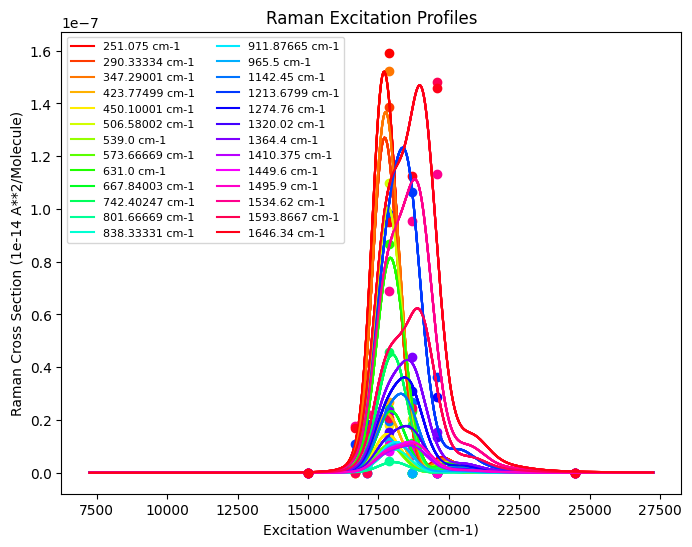

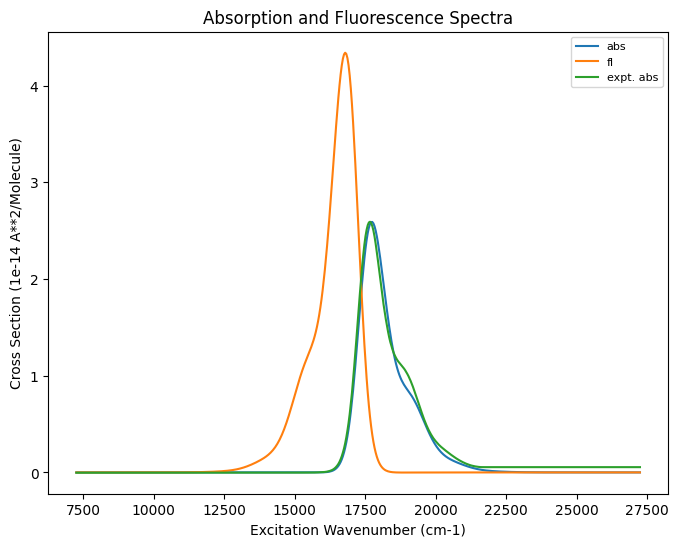

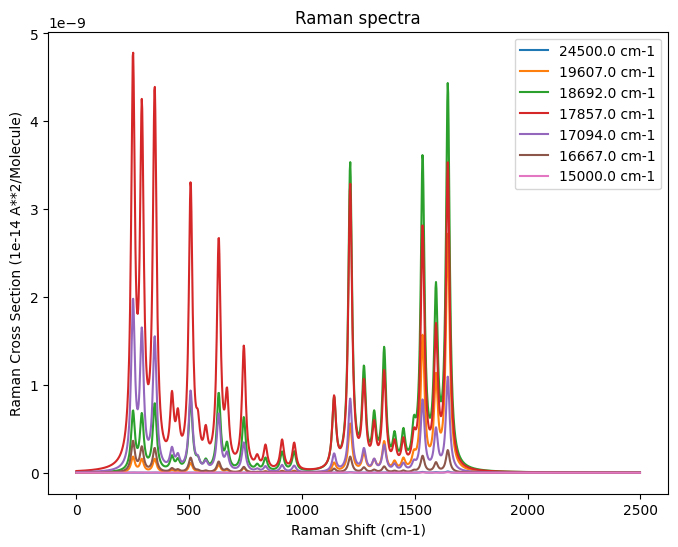

In [197]:
start_time = time.time()
for i in range(30):
    data = resram_data()#load input data from current directory
data.plot()
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

In [184]:
start_time = time.time()
for i in range(100):
    fit_obj = load_input()
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")
print(fit_obj.rp)

Elapsed time: 0.0933530330657959 seconds
[430 308 285 265 246 235 193]


<Parameter 'delta0', value=0.7748604270679489, bounds=[0.0:1.0]>
<Parameter 'delta1', value=0.6409960961625931, bounds=[0.0:1.0]>
<Parameter 'delta2', value=0.5872857740485251, bounds=[0.0:1.0]>
<Parameter 'delta3', value=0.20719247724224388, bounds=[0.0:1.0]>
<Parameter 'delta4', value=0.1607544533791192, bounds=[0.0:1.0]>
<Parameter 'delta5', value=0.3893313623373211, bounds=[0.0:1.0]>
<Parameter 'delta6', value=0.12074773193374017, bounds=[0.0:1.0]>
<Parameter 'delta7', value=0.11603393193686784, bounds=[0.0:1.0]>
<Parameter 'delta8', value=0.30537623378500867, bounds=[0.0:1.0]>
<Parameter 'delta9', value=0.15836620976768084, bounds=[0.0:1.0]>
<Parameter 'delta10', value=0.20742166396327966, bounds=[0.0:1.0]>
<Parameter 'delta11', value=0.060015796848877534, bounds=[0.0:1.0]>
<Parameter 'delta12', value=0.08745576005571493, bounds=[0.0:1.0]>
<Parameter 'delta13', value=0.0968567706185624, bounds=[0.0:1.0]>
<Parameter 'delta14', value=0.0916268892643442, bounds=[0.0:1.0]>
<Parameter 

Fitting progress:   0%|          | 0/100 [00:00<?, ?it/s]

[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 100
    # data points      = 3
    # variables        = 30
    chi-square         = 0.07259813
    reduced chi-square = 0.07259813
    Akaike info crit   = 48.8357147
    Bayesian info crit = 21.7940834
##  Warning: uncertainties could not be estimated:
[[Variables]]
    delta0:             0.77917206 (init = 0.7748604)
    delta1:             0.56385764 (init = 0.6409961)
    delta2:             0.52185921 (init = 0.5872858)
    delta3:             0.02196574 (init = 0.2071925)
    delta4:             0.14710020 (init = 0.1607545)
    delta5:             0.38959502 (init = 0.3893314)
    delta6:             0.13782333 (init = 0.1207477)
    delta7:             0.11522563 (init = 0.1160339)
    delta8:             0.30273990 (init = 0.3053762)
    delta9:             0.13503980 (init = 0.1583662)
    delta10:            0.20658497 (init = 0.2074217)
    delta11:            0.06149675 (init = 0.0600158)
    delt

C:\Users\kentc\AppData\Local\Temp\ipykernel_29160\2884032013.py:625: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_raman.show()
C:\Users\kentc\AppData\Local\Temp\ipykernel_29160\2884032013.py:660: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_profs.show()
C:\Users\kentc\AppData\Local\Temp\ipykernel_29160\2884032013.py:671: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_abs.show()


"\nplt.plot(np.arange(len(correlation_list)), np.array(\n    correlation_list)*50, label='correlation*50')\nplt.plot(np.arange(len(sigma_list)), sigma_list, label='sigma')\nplt.plot(np.arange(len(loss_list)), loss_list, label='loss')\nplt.legend(loc='best')\nplt.show()"

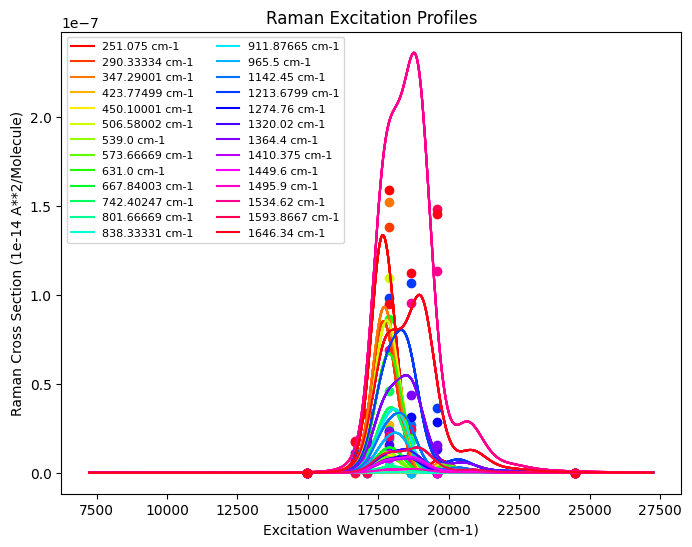

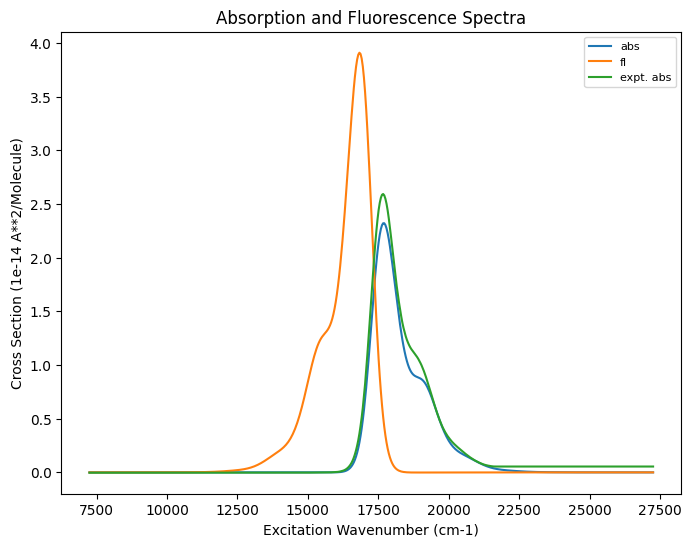

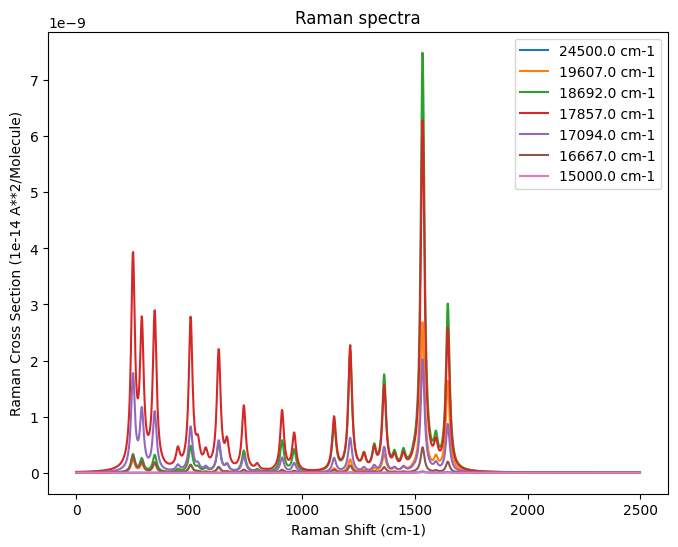

In [198]:
fit_obj = load_input() # Initialize the 'fit_obj' object of class 'load_input' .Load from input files in root dir or specified dir

fit_switch = np.ones(len(fit_obj.delta)+7)
fit_switch[len(fit_obj.delta)] = 1  # fit gamma?
fit_switch[len(fit_obj.delta)+1] = 1  # fit M?
fit_switch[len(fit_obj.delta)+2] = 1  # fit theta?
fit_switch[len(fit_obj.delta)+3] = 1  # fit kappa?
fit_switch[len(fit_obj.delta)+5] = 0  # fit E0?

correlation_list = []   # Initialize an empty list to store uvvis correlation values
sigma_list = [] # Initialize an empty list to store raman prof sigma values
loss_list = []  # Initialize an empty list to store total loss values
params_lmfit = param_init(fit_switch,fit_obj)   # Initialize parameters for fitting using 'param_init' function
# params_lmfit.add('gamma',value = 600,min = 400, max = 900)
# params_lmfit.add('transition_length',value = 1.83,min = 1.5, max = 2.3)
for name in params_lmfit.keys():
    print(params_lmfit[name])
raman_residual(params_lmfit)   # Calculate initial residuals for Raman spectroscopy
fit_kws = dict(tol=1e-9)    # Set fitting tolerance
max_nfev = 100    # Set maximum number of function evaluations

# Initialize tqdm progress bar for fitting process
with tqdm(total=max_nfev, desc="Fitting progress") as pbar:
    def update_progress(params, iteration, resid,args):
        # Update tqdm progress bar with fitting information
        global correlation, total_sigma
        pbar.update(1)
        #print(iteration,resid,args)
        pbar.set_description(
            f"Iteration {iteration}, Total Residual: {resid[0]:.7f}, Abs_corr: {correlation:.7f}, raman_sigma: {total_sigma:.7f}, delta: {fit_obj.delta}, M: {fit_obj.M}, Theta: {fit_obj.theta}, Kappa: {fit_obj.k}, E0: {fit_obj.E0}")
     # Perform the fitting using lmfit.minimize function
    result = lmfit.minimize(raman_residual, params_lmfit, args=(fit_obj,), method='cobyla', **fit_kws,
                            max_nfev=max_nfev, iter_cb=update_progress)  # max_nfev = 10000000, **fit_kws

print(lmfit.fit_report(result))
delta_fit = fit_obj.delta.copy()
output = run_save(fit_obj)  # save all parameters and results to a new folder
output.plot()
np.savetxt(current_time_str+"_data/corr_list.dat", correlation_list)
np.savetxt(current_time_str+"_data/sigma_list.dat", sigma_list)
np.savetxt(current_time_str+"_data/loss_list", loss_list)
#np.savetxt(current_time_str+"_data/delta_fit.dat",delta_fit,delimiter = "\t") #save deltas. already saved with run_save()
'''
plt.plot(np.arange(len(correlation_list)), np.array(
    correlation_list)*50, label='correlation*50')
plt.plot(np.arange(len(sigma_list)), sigma_list, label='sigma')
plt.plot(np.arange(len(loss_list)), loss_list, label='loss')
plt.legend(loc='best')
plt.show()'''


In [1]:
output.plot()

NameError: name 'output' is not defined

C:\Users\kentc\AppData\Local\Temp\ipykernel_17760\1533908424.py:514: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_raman.show()
C:\Users\kentc\AppData\Local\Temp\ipykernel_17760\1533908424.py:547: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_profs.show()
C:\Users\kentc\AppData\Local\Temp\ipykernel_17760\1533908424.py:558: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_abs.show()


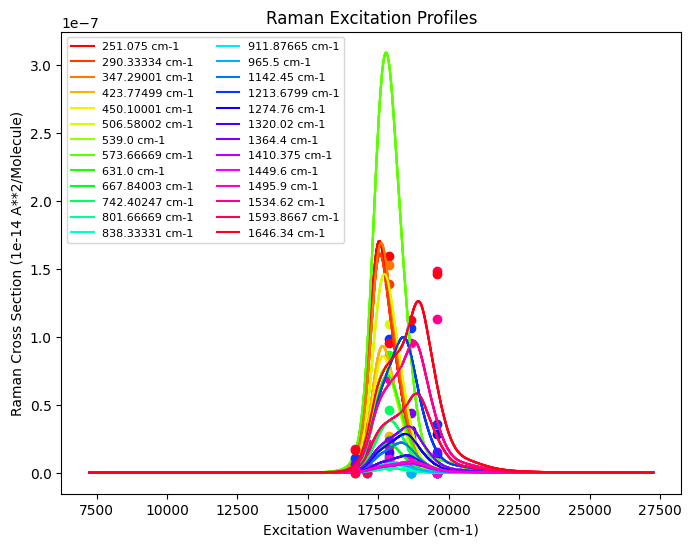

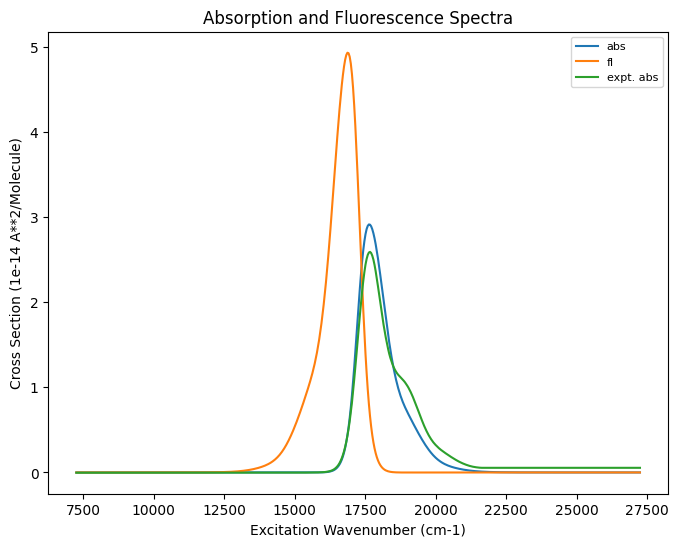

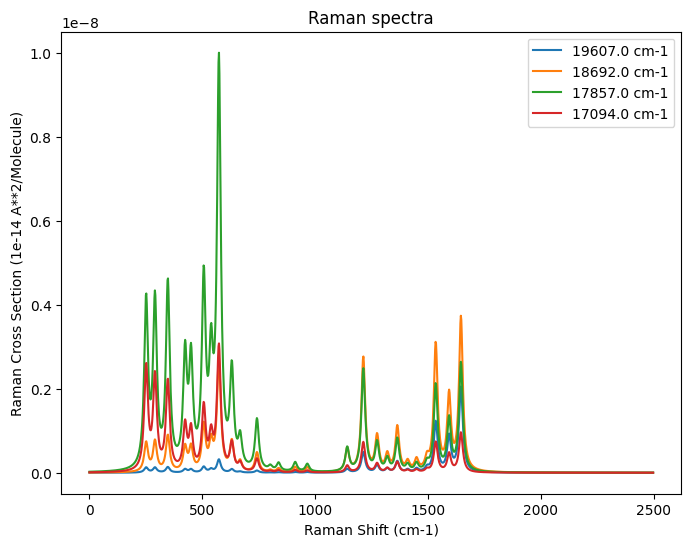

In [ ]:
load("freqs.dat","deltas.dat","rpumps.dat","inp.txt")
output = run_save()
output.plot()

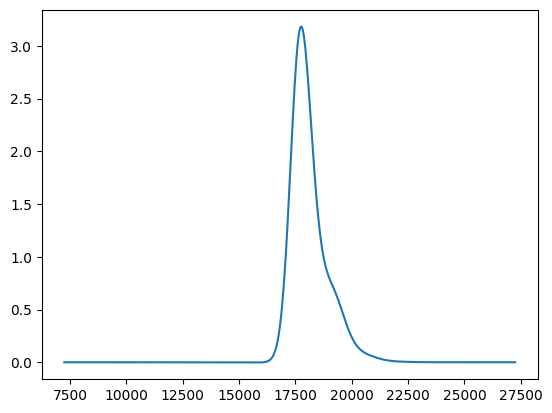

In [ ]:
plt.plot(convEL,np.real(abs_cross))
plt.show()

[-8.31604862e-06 -8.45661636e-06 -8.59965662e-06 -8.74522029e-06
 -8.89335947e-06 -9.04412751e-06 -9.19757908e-06 -9.35377019e-06
 -9.51275820e-06 -9.67460188e-06 -9.83936147e-06 -1.00070987e-05
 -1.01778768e-05 -1.03517606e-05 -1.05288167e-05 -1.07091130e-05
 -1.08927195e-05 -1.10797078e-05 -1.12701513e-05 -1.14641254e-05
 -1.16617073e-05 -1.18629763e-05 -1.20680136e-05 -1.22769027e-05
 -1.24897291e-05 -1.27065807e-05 -1.29275475e-05 -1.31527221e-05
 -1.33821994e-05 -1.36160770e-05 -1.38544548e-05 -1.40974356e-05
 -1.43451250e-05 -1.45976314e-05 -1.48550660e-05 -1.51175433e-05
 -1.53851808e-05 -1.56580991e-05 -1.59364223e-05 -1.62202780e-05
 -1.65097972e-05 -1.68051146e-05 -1.71063687e-05 -1.74137020e-05
 -1.77272610e-05 -1.80471962e-05 -1.83736626e-05 -1.87068196e-05
 -1.90468313e-05 -1.93938663e-05 -1.97480984e-05 -2.01097062e-05
 -2.04788740e-05 -2.08557910e-05 -2.12406523e-05 -2.16336590e-05
 -2.20350178e-05 -2.24449420e-05 -2.28636511e-05 -2.32913714e-05
 -2.37283361e-05 -2.41747

C:\Users\kentc\AppData\Local\Temp\ipykernel_2124\979718115.py:152: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_raman.show()
C:\Users\kentc\AppData\Local\Temp\ipykernel_2124\979718115.py:180: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_profs.show()
C:\Users\kentc\AppData\Local\Temp\ipykernel_2124\979718115.py:187: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_abs.show()


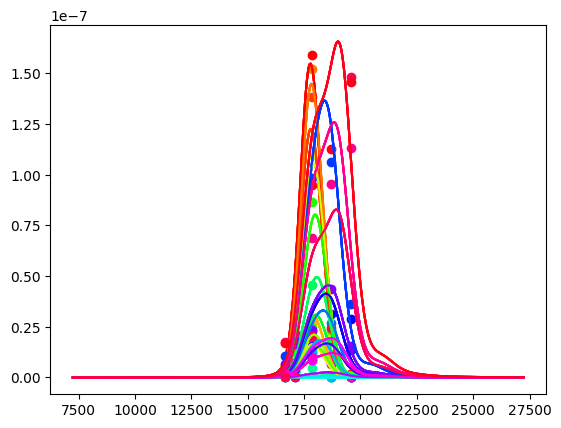

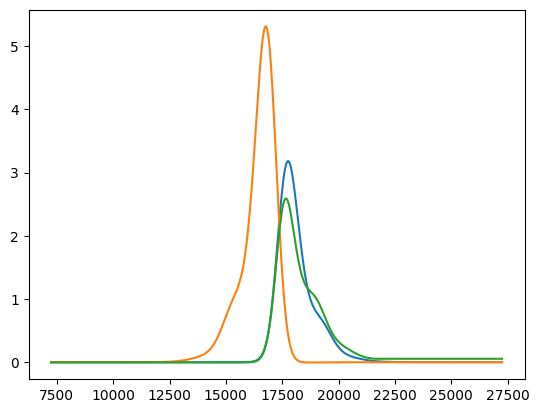

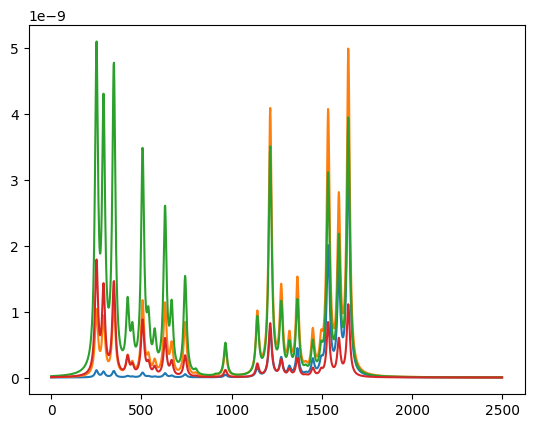

In [ ]:
output = resram_data('20231112_17-09-42_data/')
print(output.abs)
output.plot()



C:\Users\Kent\AppData\Local\Temp\ipykernel_28656\162135498.py:701: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_raman.show()
C:\Users\Kent\AppData\Local\Temp\ipykernel_28656\162135498.py:736: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_profs.show()
C:\Users\Kent\AppData\Local\Temp\ipykernel_28656\162135498.py:747: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_abs.show()


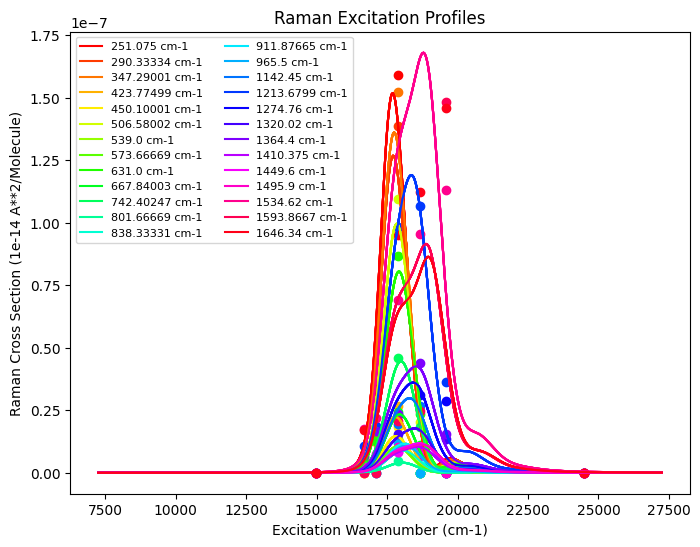

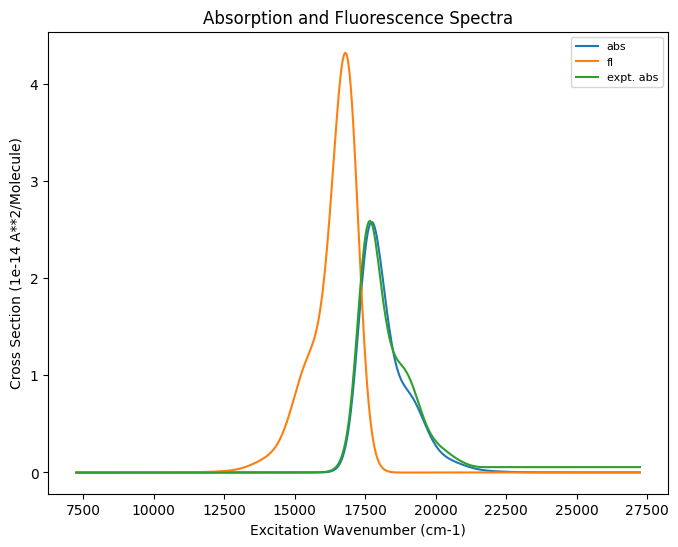

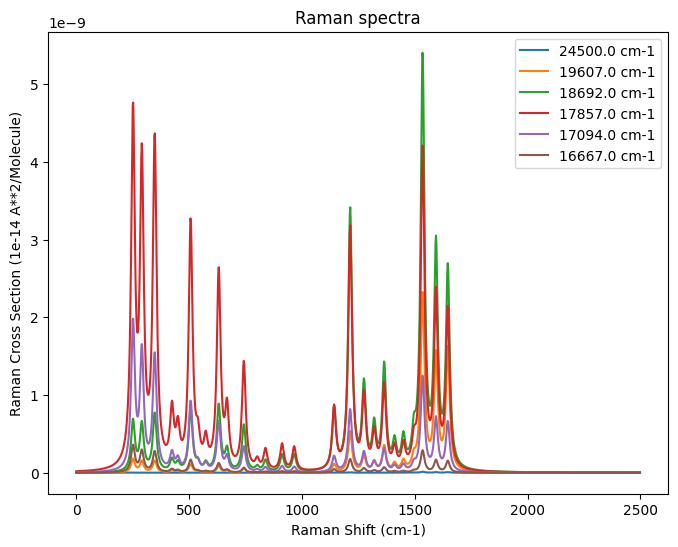

In [ ]:
#run_save(fit_obj)
output =  resram_data('20231118_00-09-25_data') 
output.plot()